# Example-01: Coupled twiss parameters

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=25):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, ks1, kn2, ks2 = k; return x
def m12(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x
def m23(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m56(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m67(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Compute one-turn transport matrix

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([0.20, -0.01, -0.25, 0.01], dtype=torch.float64)

m = torch.func.jacrev(fodo)(x, k)
print(m)

from twiss.wolski import is_stable
print(is_stable(m))

tensor([[ 4.946e-01,  2.032e+01, -8.454e-03,  3.297e-01],
        [-3.725e-02,  4.946e-01,  4.386e-03,  8.052e-03],
        [ 8.052e-03,  3.297e-01, -9.236e-02,  3.539e+00],
        [ 4.386e-03, -8.454e-03, -2.806e-01, -9.236e-02]], dtype=torch.float64)
True


In [6]:
# Compute coupled twiss parameters 

from twiss.wolski import twiss
t, n, w = twiss(m)

print(t)
print(n)
print(w)

tensor([1.677e-01, 2.647e-01], dtype=torch.float64)
tensor([[ 4.835e+00,  0.000e+00,  2.714e-02, -2.814e-16],
        [-6.488e-18,  2.069e-01,  3.388e-18, -7.283e-03],
        [ 6.634e-02, -5.239e-17,  1.884e+00,  0.000e+00],
        [-1.707e-18, -2.980e-03, -2.640e-16,  5.308e-01]], dtype=torch.float64)
tensor([[[ 2.338e+01, -3.137e-17,  3.208e-01, -8.252e-18],
         [-3.137e-17,  4.279e-02, -1.127e-17, -6.165e-04],
         [ 3.208e-01, -1.127e-17,  4.401e-03,  4.288e-20],
         [-8.252e-18, -6.165e-04,  4.288e-20,  8.880e-06]],

        [[ 7.367e-04,  2.142e-18,  5.114e-02, -1.566e-16],
         [ 2.142e-18,  5.305e-05,  6.384e-18, -3.866e-03],
         [ 5.114e-02,  6.384e-18,  3.550e+00, -4.974e-16],
         [-1.566e-16, -3.866e-03, -4.974e-16,  2.818e-01]]],
       dtype=torch.float64)


In [7]:
# Check normalization matrix

from math import pi
from twiss.matrix import rotation

print(rotation(*2*pi*t))
print(n.inverse() @ m @ n)

tensor([[4.945e-01, 8.692e-01, 0.000e+00, 0.000e+00],
        [-8.692e-01, 4.945e-01, 0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00, -9.224e-02, 9.957e-01],
        [0.000e+00, 0.000e+00, -9.957e-01, -9.224e-02]], dtype=torch.float64)
tensor([[ 4.945e-01,  8.692e-01,  1.692e-18,  2.082e-17],
        [-8.692e-01,  4.945e-01,  3.384e-17,  3.816e-17],
        [ 6.772e-18,  4.424e-17, -9.224e-02,  9.957e-01],
        [ 7.236e-18,  3.578e-18, -9.957e-01, -9.224e-02]], dtype=torch.float64)


In [8]:
# Check twiss matrices

from twiss.matrix import symplectic_identity

s = symplectic_identity(len(w), dtype=torch.float64)
u = torch.zeros_like(m)
for ti, wi in zip(t, w):
    u += (wi @ s) * (2*pi*ti).sin() - (wi @ s) @ (wi @ s) * (2*pi*ti).cos()

print(m)
print(u)

tensor([[ 4.946e-01,  2.032e+01, -8.454e-03,  3.297e-01],
        [-3.725e-02,  4.946e-01,  4.386e-03,  8.052e-03],
        [ 8.052e-03,  3.297e-01, -9.236e-02,  3.539e+00],
        [ 4.386e-03, -8.454e-03, -2.806e-01, -9.236e-02]], dtype=torch.float64)
tensor([[ 4.946e-01,  2.032e+01, -8.454e-03,  3.297e-01],
        [-3.725e-02,  4.946e-01,  4.386e-03,  8.052e-03],
        [ 8.052e-03,  3.297e-01, -9.236e-02,  3.539e+00],
        [ 4.386e-03, -8.454e-03, -2.806e-01, -9.236e-02]], dtype=torch.float64)


In [9]:
# Compute twiss at each location

from twiss.wolski import propagate  

out = []
for mapping in (m11, m12, m23, m34, m45, m56, m67, m78, m89):
    w = propagate(w, torch.func.jacrev(mapping)(x, k))
    out.append(w)
out = torch.stack(out)

print(out.shape)

torch.Size([9, 2, 4, 4])


In [10]:
# Convert to CS and LB represencation 

from twiss.convert import  wolski_to_cs
from twiss.convert import  wolski_to_lb

ax, bx, ay, by = torch.vmap(wolski_to_cs)(out).T
a1x, b1x, a2x, b2x, a1y, b1y, a2y, b2y, *_ = torch.vmap(wolski_to_lb)(out).T

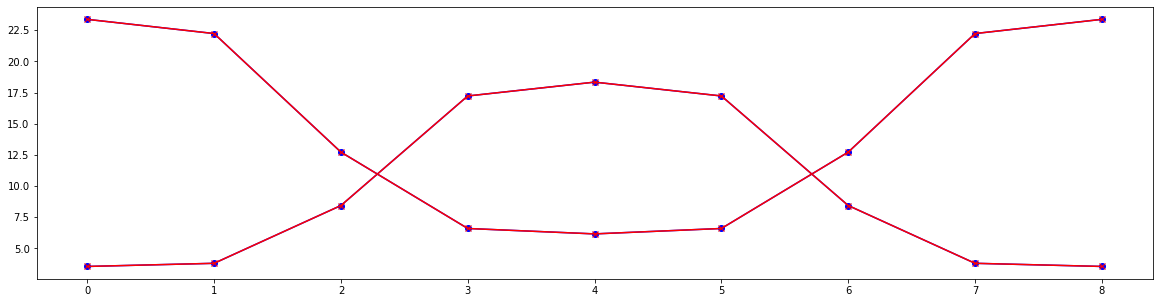

In [11]:
# Plot in-plane twiss parameters

from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(range(9), bx, marker='o', color='blue')
plt.plot(range(9), b1x, marker='x', color='red')
plt.plot(range(9), by, marker='o', color='blue')
plt.plot(range(9), b2y, marker='x', color='red')
plt.show()

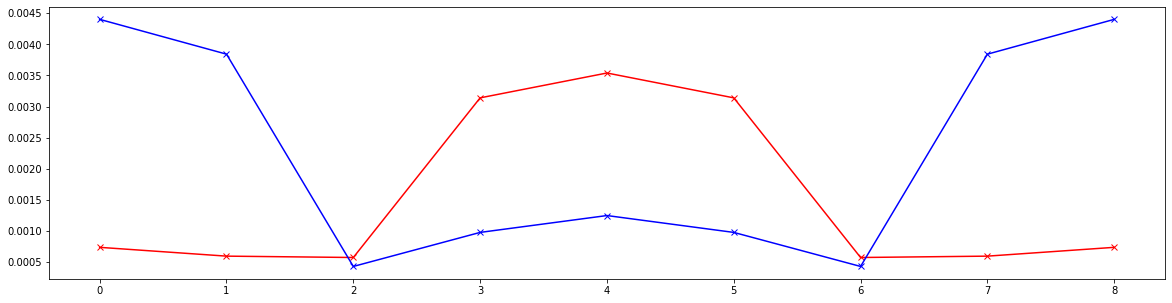

In [12]:
# Plot in-plane coupled twiss parameters

from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(range(9), b2x, marker='x', color='red')
plt.plot(range(9), b1y, marker='x', color='blue')
plt.show()

In [13]:
# Compute phase advances

from twiss.wolski import advance

out = []
for mapping in (m11, m12, m23, m34, m45, m56, m67, m78, m89):
    mu, n = advance(n, torch.func.jacrev(mapping)(x, k))
    out.append(mu)
out = torch.stack(out)

print(t)
print(1/(2*pi)*out.T.sum(-1))

tensor([1.677e-01, 2.647e-01], dtype=torch.float64)
tensor([1.677e-01, 2.647e-01], dtype=torch.float64)


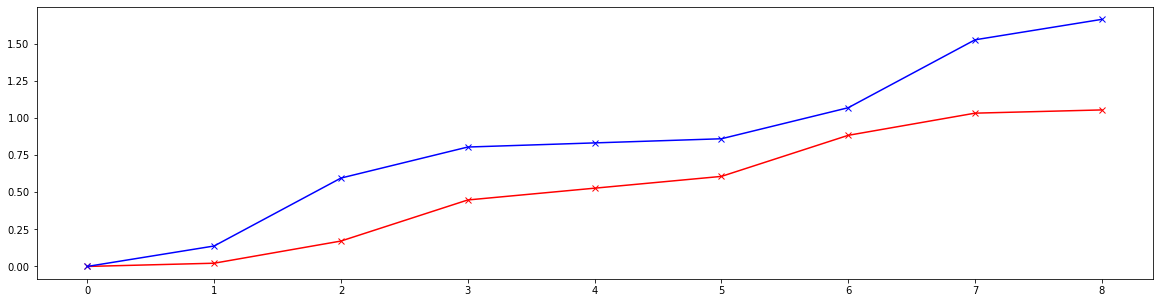

In [14]:
# Plot accumulated phase advance

mux, muy = out.T.cumsum(-1)

plt.figure(figsize=(20, 5))
plt.plot(range(9), mux, marker='x', color='red')
plt.plot(range(9), muy, marker='x', color='blue')
plt.show()

# Example-02: Tune derivatives

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=25):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, ks1, kn2, ks2 = k; return x
def m12(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x
def m23(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m56(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m67(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Compute tune derivatives

from twiss.wolski import twiss

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([0.20, 0.0, -0.25, 0.0], dtype=torch.float64)

def fn(k):
    m = torch.func.jacrev(fodo)(x, k)
    t, *_ = twiss(m)
    return t

d1 = torch.func.jacrev(fn)(k)
d2 = torch.func.jacrev(torch.func.jacrev(fn))(k)

print(d1)
print(d2)

tensor([[1.832e+00, 0.000e+00, 5.027e-01, 0.000e+00],
        [-2.894e-01, 0.000e+00, -1.430e+00, 0.000e+00]], dtype=torch.float64)
tensor([[[-1.265e+01, 0.000e+00, -6.634e+00, 0.000e+00],
         [0.000e+00, -1.186e+01, 0.000e+00, -1.682e+01],
         [-6.634e+00, 0.000e+00, -1.069e+00, 0.000e+00],
         [0.000e+00, -1.682e+01, 0.000e+00, -1.547e+01]],

        [[-4.998e-02, 0.000e+00, -2.576e+00, 0.000e+00],
         [0.000e+00, 9.716e+00, 0.000e+00, 8.931e+00],
         [-2.576e+00, 0.000e+00, 7.011e-01, 0.000e+00],
         [0.000e+00, 8.931e+00, 0.000e+00, 1.286e+01]]], dtype=torch.float64)


In [6]:
# Test

dk = torch.tensor([0.005, -0.005, -0.005, 0.005], dtype=torch.float64)

print(fn(k))
print(fn(k) + d1 @ dk)
print(fn(k) + d1 @ dk + 1/2 * d2 @ dk @ dk)
print()

t, *_ = twiss(torch.func.jacrev(fodo)(x, k + dk))
print(t)
print()

tensor([1.674e-01, 2.645e-01], dtype=torch.float64)
tensor([1.740e-01, 2.702e-01], dtype=torch.float64)
tensor([1.741e-01, 2.703e-01], dtype=torch.float64)

tensor([1.741e-01, 2.703e-01], dtype=torch.float64)



# Example-03: Twiss derivatives

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=25):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, ks1, kn2, ks2 = k; return x
def m12(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x
def m23(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m56(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m67(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Set task function

from twiss.wolski import twiss
from twiss.wolski import propagate
from twiss.convert import wolski_to_cs

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([0.20, 0.0, -0.25, 0.0], dtype=torch.float64)

def fn(k):
    m = torch.func.jacrev(fodo)(x, k)
    *_, w = twiss(m)
    out = []
    for mapping in (m11, m12, m23, m34, m45, m56, m67, m78, m89):
        w = propagate(w, torch.func.jacrev(mapping)(x, k))
        out.append(w)
    out = torch.stack(out)
    ax, bx, ay, by = torch.vmap(wolski_to_cs)(out).T
    return torch.stack([bx, by]).T

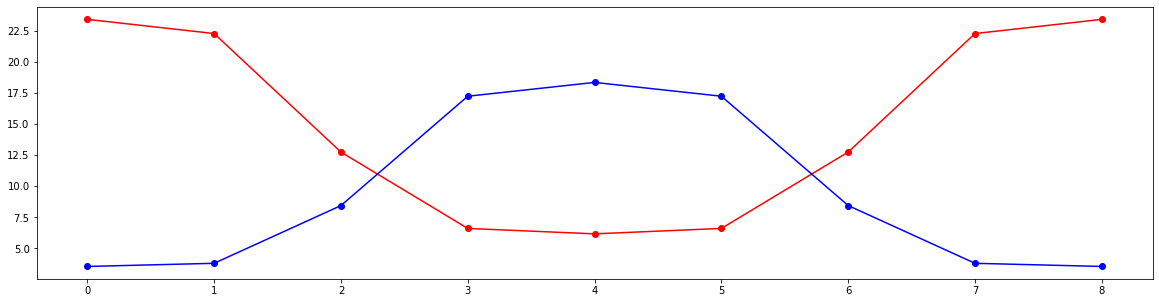

In [6]:
# Compute and plot twiss

bx, by = fn(k).T

from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(range(9), bx, marker='o', color='red')
plt.plot(range(9), by, marker='o', color='blue')
plt.show()

In [7]:
# Compute twiss derivatives

d1 = torch.func.jacrev(fn)(k)
print(d1.shape)

torch.Size([9, 2, 4])


In [8]:
# Test

dk = torch.tensor([0.005, -0.005, -0.005, 0.005], dtype=torch.float64)

print(fn(k).T)
print((fn(k) + d1 @ dk).T)
print()

print(fn(k + dk).T)
print()

tensor([[2.341e+01, 2.226e+01, 1.274e+01, 6.608e+00, 6.173e+00, 6.608e+00, 1.274e+01, 2.226e+01, 2.341e+01],
        [3.554e+00, 3.806e+00, 8.444e+00, 1.723e+01, 1.834e+01, 1.723e+01, 8.444e+00, 3.806e+00, 3.554e+00]],
       dtype=torch.float64)
tensor([[2.303e+01, 2.188e+01, 1.232e+01, 6.251e+00, 5.827e+00, 6.251e+00, 1.232e+01, 2.188e+01, 2.303e+01],
        [3.395e+00, 3.647e+00, 8.370e+00, 1.741e+01, 1.856e+01, 1.741e+01, 8.370e+00, 3.647e+00, 3.395e+00]],
       dtype=torch.float64)

tensor([[2.305e+01, 2.190e+01, 1.234e+01, 6.262e+00, 5.838e+00, 6.262e+00, 1.234e+01, 2.190e+01, 2.305e+01],
        [3.396e+00, 3.648e+00, 8.373e+00, 1.742e+01, 1.857e+01, 1.742e+01, 8.373e+00, 3.648e+00, 3.396e+00]],
       dtype=torch.float64)



# Example-04: Phase advance derivatives

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=25):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, ks1, kn2, ks2 = k; return x
def m12(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x
def m23(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m56(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m67(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Set task function

from twiss.wolski import twiss
from twiss.wolski import advance

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([0.20, 0.0, -0.25, 0.0], dtype=torch.float64)

def fn(k):
    m = torch.func.jacrev(fodo)(x, k)
    _, n, _ = twiss(m)
    out = []
    for mapping in (m12, m23, m34, m45, m56, m67, m78, m89):
        mu, n = advance(n, torch.func.jacrev(mapping)(x, k))
        out.append(mu)
    return torch.stack(out)

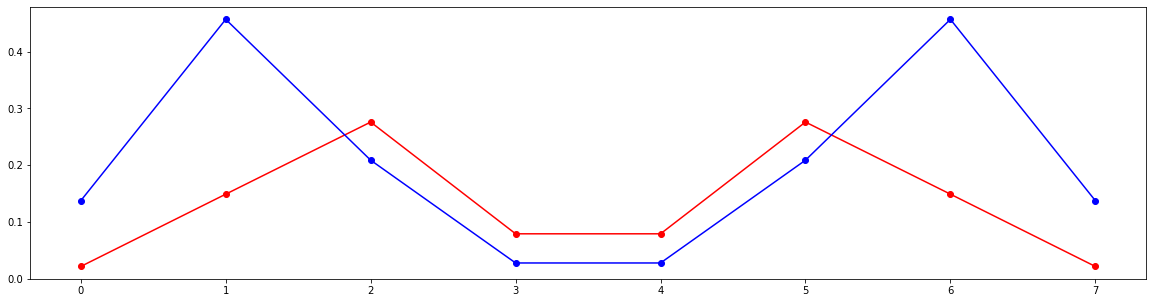

In [6]:
# Compute and plot phase advance

mux, muy = fn(k).T

from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(range(8), mux, marker='o', color='red')
plt.plot(range(8), muy, marker='o', color='blue')
plt.show()

In [7]:
# Compute phase advance derivatives

d1 = torch.func.jacrev(fn)(k)
print(d1.shape)

torch.Size([8, 2, 4])


In [8]:
# Test

dk = torch.tensor([0.005, -0.005, -0.005, 0.005], dtype=torch.float64)

print(fn(k).T)
print((fn(k) + d1 @ dk).T)
print()

print(fn(k + dk).T)
print()

tensor([[2.172e-02, 1.490e-01, 2.759e-01, 7.918e-02, 7.918e-02, 2.759e-01, 1.490e-01, 2.172e-02],
        [1.375e-01, 4.567e-01, 2.088e-01, 2.784e-02, 2.784e-02, 2.088e-01, 4.567e-01, 1.375e-01]],
       dtype=torch.float64)
tensor([[2.208e-02, 1.528e-01, 2.883e-01, 8.357e-02, 8.357e-02, 2.883e-01, 1.528e-01, 2.208e-02],
        [1.435e-01, 4.691e-01, 2.086e-01, 2.752e-02, 2.752e-02, 2.086e-01, 4.691e-01, 1.435e-01]],
       dtype=torch.float64)

tensor([[2.206e-02, 1.527e-01, 2.884e-01, 8.368e-02, 8.368e-02, 2.884e-01, 1.527e-01, 2.206e-02],
        [1.438e-01, 4.694e-01, 2.085e-01, 2.751e-02, 2.751e-02, 2.085e-01, 4.694e-01, 1.438e-01]],
       dtype=torch.float64)



# Example-05: Tune uncertainty from systematic errors

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=25):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, ks1, kn2, ks2 = k; return x
def m12(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x
def m23(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m56(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 0.5); return x
def m67(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Compute tune derivatives

from twiss.wolski import twiss

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([0.20, 0.0, -0.25, 0.0], dtype=torch.float64)

def fn(k):
    m = torch.func.jacrev(fodo)(x, k)
    t, *_ = twiss(m)
    return t

grad = torch.func.jacrev(fn)(k)

In [6]:
# Compute tune uncertainty for given known knobs uncertanties

sk = torch.tensor([0.01, 0.005, 0.01, 0.005], dtype=torch.float64)

st = (grad**2 @ sk**2).sqrt()
print(st)

st = torch.func.vmap(fn)(k + sk * torch.randn((1024, 4), dtype=torch.float64)).T.std(-1)
print(st)

tensor([1.900e-02, 1.459e-02], dtype=torch.float64)
tensor([1.952e-02, 1.420e-02], dtype=torch.float64)


# Example-06: Matching (composable)

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=25):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, kn2 = k; return x
def m12(x, k): kn1, kn2 = k; x = quad(x, kn1, 0.0, 0.5); return x
def m23(x, k): kn1, kn2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, kn2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, kn2 = k; x = quad(x, kn2, 0.0, 0.5); return x
def m56(x, k): kn1, kn2 = k; x = quad(x, kn2, 0.0, 0.5); return x
def m67(x, k): kn1, kn2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, kn2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, kn2 = k; x = quad(x, kn1, 0.0, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Set objective function (bx & by at focusing quadrupole center)

from twiss.wolski import twiss
from twiss.convert import wolski_to_cs

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([+0.20, -0.20], dtype=torch.float64)

BX, BY = torch.tensor([25.0, 5.0], dtype=torch.float64)

bag = []

def objective(k, flag=False):
    m = torch.func.jacrev(fodo)(x, k)
    *_, w = twiss(m)
    ax, bx, ay, by = wolski_to_cs(w)
    if flag:
        bag.append(torch.stack([bx, by]))
    return (bx - BX)**2 +  (by - BY)**2

In [6]:
# Set optimizer

def adam(objective, knobs, count=1, lr=0.005, betas=(0.900, 0.999), epsilon=1.0E-9):
    b1, b2 = betas
    history_knobs = []
    history_value = []
    m1 = torch.zeros_like(knobs)
    m2 = torch.zeros_like(knobs)
    for i in range(count):
        grad = torch.func.jacrev(objective)(knobs)
        m1 = b1 * m1 + (1.0 - b1) * grad
        m2 = b2 * m2 + (1.0 - b2) * grad ** 2
        f1 = 1/(1 - b1 ** (i + 1))
        f2 = 1/(1 - b2 ** (i + 1))
        knobs = knobs -  lr * m1 / f1 / (torch.sqrt(m2 / f2) + epsilon)
        value = objective(knobs, flag=True)
        history_knobs.append(knobs)
        history_value.append(value)
    return tuple(map(torch.stack, [history_knobs, history_value]))

In [7]:
# Optimize

knobs, value = adam(objective, k, count=128, lr=0.001)

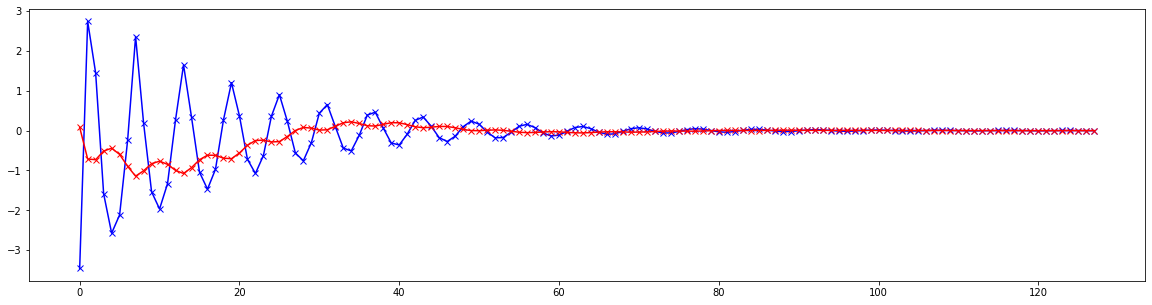

In [8]:
# Plot beta values

from matplotlib import pyplot as plt

bxs, bys = torch.stack(bag).T

plt.figure(figsize=(20, 5))
plt.plot(range(128), (bxs - BX).cpu().numpy(), color='blue', marker='x')
plt.plot(range(128), (bys - BY).cpu().numpy(), color='red', marker='x')
plt.show()

# Example-07: Matching (autograd)

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=25):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, kn2 = k; return x
def m12(x, k): kn1, kn2 = k; x = quad(x, kn1, 0.0, 0.5); return x
def m23(x, k): kn1, kn2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, kn2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, kn2 = k; x = quad(x, kn2, 0.0, 0.5); return x
def m56(x, k): kn1, kn2 = k; x = quad(x, kn2, 0.0, 0.5); return x
def m67(x, k): kn1, kn2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, kn2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, kn2 = k; x = quad(x, kn1, 0.0, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Set objective function (bx & by at focusing quadrupole center)

from twiss.wolski import twiss
from twiss.convert import wolski_to_cs

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([+0.20, -0.20], dtype=torch.float64)

BX, BY = torch.tensor([25.0, 5.0], dtype=torch.float64)

def objective(k):
    m = torch.func.jacrev(fodo)(x, k)
    *_, w = twiss(m)
    ax, bx, ay, by = wolski_to_cs(w)
    return (bx - BX)**2 +  (by - BY)**2

In [6]:
# Define model

class Model(torch.nn.Module):
    
    def __init__(self, objective, knobs):
        super().__init__()
        self.objective = objective
        self.knobs = torch.nn.Parameter(torch.clone(knobs))

    def forward(self):
        return self.objective(self.knobs)
    
model = Model(objective, k)

In [7]:
# Set optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [8]:
# Train
# Note, here forward method is a loss function

model.train()

for _ in range(256):
    loss = model()
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

In [9]:
# Check result

k = torch.stack([*model.parameters()]).detach().squeeze()
m = torch.func.jacrev(fodo)(x, k)
*_, w = twiss(m)
ax, bx, ay, by = wolski_to_cs(w)
print(torch.stack([bx, by]))

tensor([2.500e+01, 5.000e+00], dtype=torch.float64)


# Example-08: Matching (autograd & taylor model)

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=25):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, kn2 = k; return x
def m12(x, k): kn1, kn2 = k; x = quad(x, kn1, 0.0, 0.5); return x
def m23(x, k): kn1, kn2 = k; x = drif(x, 2.5); return x
def m34(x, k): kn1, kn2 = k; x = drif(x, 2.5); return x
def m45(x, k): kn1, kn2 = k; x = quad(x, kn2, 0.0, 0.5); return x
def m56(x, k): kn1, kn2 = k; x = quad(x, kn2, 0.0, 0.5); return x
def m67(x, k): kn1, kn2 = k; x = drif(x, 2.5); return x
def m78(x, k): kn1, kn2 = k; x = drif(x, 2.5); return x
def m89(x, k): kn1, kn2 = k; x = quad(x, kn1, 0.0, 0.5); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    x = m56(x, k)
    x = m67(x, k)
    x = m78(x, k)
    x = m89(x, k)
    return x

In [5]:
# Compute parametric transport matrix

from ndtorch.derivative import derivative
from ndtorch.evaluate import evaluate

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([+0.20, -0.20], dtype=torch.float64)
t = derivative(4, lambda k: torch.func.jacrev(fodo)(x, k), k, jacobian=torch.func.jacfwd)

In [6]:
# Set objective function (bx & by at focusing quadrupole center)

from twiss.wolski import twiss
from twiss.convert import wolski_to_cs

dk = torch.tensor([0.0, 0.0], dtype=torch.float64)

BX, BY = torch.tensor([25.0, 5.0], dtype=torch.float64)

def objective(k):
    m = evaluate(t, [k])
    *_, w = twiss(m)
    ax, bx, ay, by = wolski_to_cs(w)
    return torch.stack([bx, by])

In [7]:
# Define model

class Model(torch.nn.Module):
    
    def __init__(self, objective, knobs):
        super().__init__()
        self.objective = objective
        self.knobs = torch.nn.Parameter(torch.clone(knobs))

    def forward(self):
        return self.objective(self.knobs)
    
model = Model(objective, dk)

In [8]:
# Set optimizer

optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [9]:
# Set loss function

mse = torch.nn.MSELoss()

In [10]:
# Train

model.train()

data = []

for _ in range(256):
    beta = model()
    loss = mse(beta, torch.stack([BX, BY]))
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    data.append(loss.item())

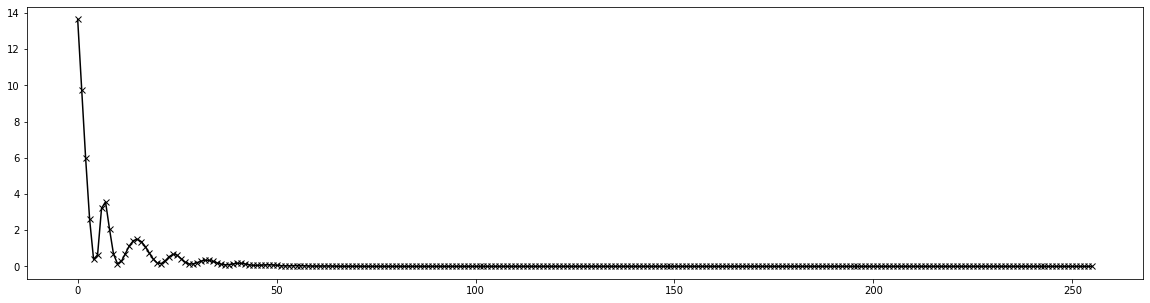

In [11]:
# Plot loss

from matplotlib import pyplot as plt

plt.figure(figsize=(20, 5))
plt.plot(range(256), data, color='black', marker='x')
plt.show()

In [12]:
# Check result

dk = torch.stack([*model.parameters()]).detach().squeeze()
m = torch.func.jacrev(fodo)(x, k + dk)
*_, w = twiss(m)
ax, bx, ay, by = wolski_to_cs(w)
print(torch.stack([bx, by]))

tensor([2.500e+01, 5.000e+00], dtype=torch.float64)


# Example-09: Matched distribution

In [1]:
import torch
torch.set_printoptions(precision=3, sci_mode=True)

In [2]:
# Set elements

def drif(x, l):
    (qx, px, qy, py), l = x, l
    return torch.stack([qx + l*px, px, qy + l*py, py])

def quad(x, kn, ks, l, n=25):
    (qx, px, qy, py), kn, ks, l = x, kn, ks, l/(2.0*n)
    for _ in range(n):
        qx, qy = qx + l*px, qy + l*py
        px, py = px - 2.0*l*(kn*qx - ks*qy), py + 2.0*l*(ks*qx + kn*qy)
        qx, qy = qx + l*px, qy + l*py
    return torch.stack([qx, px, qy, py]) 

In [3]:
# Set transport maps

def m11(x, k): kn1, ks1, kn2, ks2 = k; return x
def m12(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 5.0); return x
def m23(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn2, ks2, 1.0); return x
def m34(x, k): kn1, ks1, kn2, ks2 = k; x = drif(x, 5.0); return x
def m45(x, k): kn1, ks1, kn2, ks2 = k; x = quad(x, kn1, ks1, 1.0); return x

In [4]:
# Set fodo cell

def fodo(x, k):
    x = m11(x, k)
    x = m12(x, k)
    x = m23(x, k)
    x = m34(x, k)
    x = m45(x, k)
    return x

In [5]:
# Compute one-turn transport matrix

x = torch.tensor([0.0, 0.0, 0.0, 0.0], dtype=torch.float64)
k = torch.tensor([0.20, -0.01, -0.25, 0.01], dtype=torch.float64)

m = torch.func.jacrev(fodo)(x, k)
print(m)

from twiss.wolski import is_stable
print(is_stable(m))

tensor([[ 2.443e+00,  1.933e+01,  6.129e-02,  3.072e-01],
        [-2.357e-01, -1.454e+00,  2.789e-03, -4.458e-02],
        [ 5.838e-02,  2.911e-01, -6.017e-01,  3.789e+00],
        [-3.216e-03, -7.752e-02, -3.310e-01,  4.167e-01]], dtype=torch.float64)
True


In [6]:
# Compute coupled twiss parameters 

from twiss.wolski import twiss
*_, ws = twiss(m)

In [7]:
# Generate beam

from torch.distributions.multivariate_normal import MultivariateNormal

ex = 1.0E-6
ey = 1.0E-8

wx, wy = ws

mean = torch.zeros(4, dtype=torch.float64)
covariance_matrix = ex*wx + ey*wy

distribution = MultivariateNormal(mean, covariance_matrix)

beam = distribution.sample((2**14, )).T

print(covariance_matrix)
print()

print(distribution.covariance_matrix)
print()

print(beam.cov())
print()

tensor([[ 2.224e-05, -2.241e-06,  2.924e-07, -8.274e-08],
        [-2.241e-06,  2.709e-07, -3.030e-08,  7.656e-09],
        [ 2.924e-07, -3.030e-08,  4.186e-08,  4.045e-09],
        [-8.274e-08,  7.656e-09,  4.045e-09,  3.639e-09]], dtype=torch.float64)

tensor([[ 2.224e-05, -2.241e-06,  2.924e-07, -8.274e-08],
        [-2.241e-06,  2.709e-07, -3.030e-08,  7.656e-09],
        [ 2.924e-07, -3.030e-08,  4.186e-08,  4.045e-09],
        [-8.274e-08,  7.656e-09,  4.045e-09,  3.639e-09]], dtype=torch.float64)

tensor([[ 2.258e-05, -2.270e-06,  3.068e-07, -8.127e-08],
        [-2.270e-06,  2.737e-07, -3.132e-08,  7.566e-09],
        [ 3.068e-07, -3.132e-08,  4.250e-08,  4.150e-09],
        [-8.127e-08,  7.566e-09,  4.150e-09,  3.737e-09]], dtype=torch.float64)



In [8]:
# Same with distribution function

from twiss.beam import distribution

bd = distribution(mean, torch.tensor([ex, ey], dtype=torch.float64), ws)

beam = bd.sample((2**14, )).T

print(bd.covariance_matrix)
print()

print(beam.cov())
print()

tensor([[ 2.224e-05, -2.241e-06,  2.924e-07, -8.274e-08],
        [-2.241e-06,  2.709e-07, -3.030e-08,  7.656e-09],
        [ 2.924e-07, -3.030e-08,  4.186e-08,  4.045e-09],
        [-8.274e-08,  7.656e-09,  4.045e-09,  3.639e-09]], dtype=torch.float64)

tensor([[ 2.242e-05, -2.256e-06,  2.943e-07, -8.406e-08],
        [-2.256e-06,  2.712e-07, -3.072e-08,  7.747e-09],
        [ 2.943e-07, -3.072e-08,  4.132e-08,  3.877e-09],
        [-8.406e-08,  7.747e-09,  3.877e-09,  3.637e-09]], dtype=torch.float64)



In [9]:
# Transformed beam covariance matrix (matrix)

print((m @ beam).cov())

tensor([[ 2.207e-05, -2.237e-06,  2.902e-07, -8.037e-08],
        [-2.237e-06,  2.718e-07, -3.016e-08,  7.510e-09],
        [ 2.902e-07, -3.016e-08,  4.220e-08,  4.181e-09],
        [-8.037e-08,  7.510e-09,  4.181e-09,  3.601e-09]], dtype=torch.float64)


In [10]:
# Transformed beam covariance matrix (map)

beam = torch.func.vmap(lambda x: fodo(x, k))(beam.T).T

print(beam.cov())

tensor([[ 2.207e-05, -2.237e-06,  2.902e-07, -8.037e-08],
        [-2.237e-06,  2.718e-07, -3.016e-08,  7.510e-09],
        [ 2.902e-07, -3.016e-08,  4.220e-08,  4.181e-09],
        [-8.037e-08,  7.510e-09,  4.181e-09,  3.601e-09]], dtype=torch.float64)


In [11]:
# Prepare data frame for plotting

import pandas

df = pandas.DataFrame(beam.T.cpu().numpy())
df.columns = ['qx', 'px', 'qy', 'py']
df

,qx,px,qy,py
0,0.001170,-0.000416,0.000103,0.000029
1,-0.005233,0.000350,-0.000429,-0.000102
2,-0.002217,0.000525,0.000127,0.000028
3,-0.000162,0.000225,0.000340,0.000031
4,0.003292,-0.000302,-0.000155,-0.000074
...,...,...,...,...
16379,-0.000195,0.000328,-0.000051,-0.000052
16380,0.009093,-0.001175,0.000081,-0.000031
16381,-0.004319,0.000524,-0.000298,-0.000023
16382,0.000678,-0.000255,0.000462,0.000018


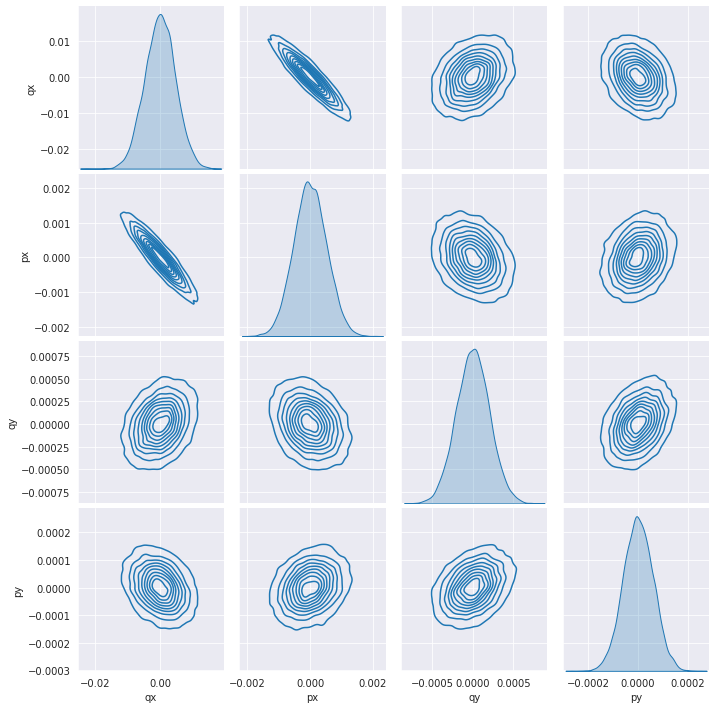

In [12]:
# Plot beam 

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

sns.pairplot(df, kind='kde')
plt.show()